## Libraries

In [4]:
import codecs
import json
import markdown
import math
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
import spacy
import textacy
import textacy.tm
import textacy.preprocessing
import umap.umap_ as umap

from pointgrid import align_points_to_grid


# from planar import Polygon # It's not working anymore
from wordcloud import WordCloud, get_single_color_func
from PIL import Image, ImageDraw
import multidict as multidict
from scipy.spatial import ConvexHull
from scipy import interpolate

## Dataset

In [5]:
with open('PAP.md', 'r') as f: md = f.read()
pages = md.split("\n") # Split in pages

len(pages)

56

## Text Analysis

In [6]:
en = textacy.load_spacy_lang("en_core_web_lg", disable=("parser",))

docs = [] # spaCy collector

for index, page in enumerate(pages):
    doc = textacy.make_spacy_doc(page, lang=en)
    docs.append(doc)

len(docs)
    

56

# Lematization

In [7]:
from functools import partial

lemmas_collector = [] # lemmas collector

for doc in docs:

    # Lemmas extraction
    config = partial(textacy.extract.ngrams, n=[1], include_pos={'NOUN'})
    terms = textacy.extract.terms(doc, ngs=config)
    lemmas = textacy.extract.terms_to_strings(terms, by="lemma")
    
    # Cleaning
    stopwords = {'pap'}
    lemmas = [l for l in lemmas if not any(stopword in l for stopword in stopwords)]
    lemmas = [l for l in lemmas if not '||||' in l]
        
    lemmas_collector.append(list(lemmas))

# Transform one or more tokenized documents into a document-term matrix of shape
# (# docs, # unique terms), with flexible weighting/normalization of values.
doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(lemmas_collector, tf_type="linear", idf_type="smooth")

print('vocabulary\'s rows are', doc_term_matrix.shape[0])
print('vocabulary\'s length is', doc_term_matrix.shape[1])


vocabulary's rows are 56
vocabulary's length is 477


## UMAP

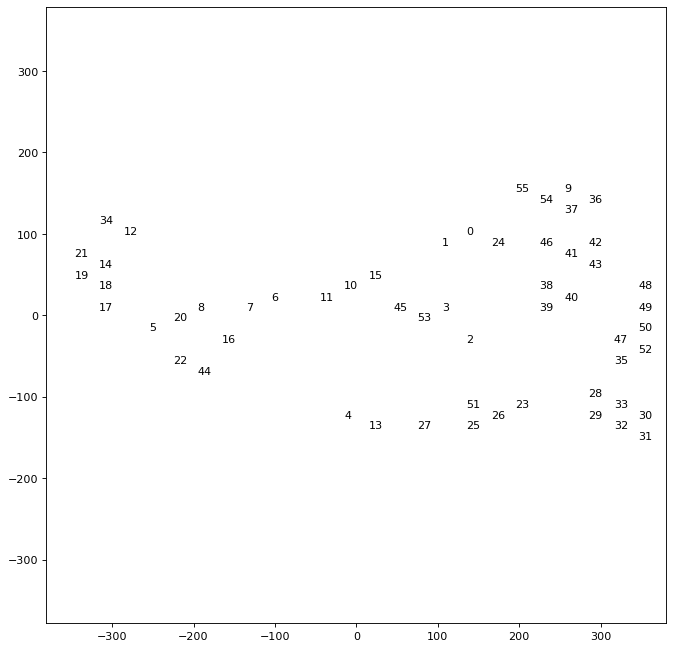

In [8]:
# UMAP
reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=5, min_dist=0.01, metric='cosine')
embedding = reducer.fit_transform(doc_term_matrix)

# Normalization
embedding = embedding * 100 # Multiply by 100
embedding = align_points_to_grid(embedding)

# Swap axes for horizontal position
ptp = np.ptp(embedding, axis=0)
if ptp[1]> ptp[0]:
    embedding[:, [1, 0]] = embedding[:, [0, 1]]

# Set value starting from 0
embedding[:, 0] = embedding[:, 0] - embedding[:, 0].min()
embedding[:, 1] = embedding[:, 1] - embedding[:, 1].min()

# Set origin at the middle
ptp = np.ptp(embedding, axis=0)
embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

# Transform coordinates in integer
embedding = embedding.astype(int)

# Draw
plt.figure(figsize=(10,10), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1], s=0)
plt.axis('equal')

for i, row in enumerate(embedding):
    text = plt.annotate(i, (row[0], row[1]))
    text.set_fontsize(10)

plt.show()
    

## Cluster Identification

In [9]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=4, cluster_selection_method='leaf')
clusterer.fit(embedding)
clusters = clusterer.labels_

# Grouping by cluster
values = set(clusters)
if -1 in values: values.remove(-1)

clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

len(clusters)

6

# Save Files

In [10]:
json.dump(embedding.tolist(), codecs.open('../src/data/embedding.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(lemmas_collector, codecs.open('../src/data/lemmas.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(clusters, codecs.open('../src/data/clusters.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

# Word Clouds

In [11]:
for index, cluster in enumerate(clusters):

    # Preprocessing

    scale = 4
    
    min_X = min([i[0] for i in embedding[cluster]]) * scale
    max_X = max([i[0] for i in embedding[cluster]]) * scale
    min_Y = min([i[1] for i in embedding[cluster]]) * scale
    max_Y = max([i[1] for i in embedding[cluster]]) * scale

    width = max_X - min_X; height = max_Y - min_Y
    
    points = list(map(lambda i: (i[0] * scale - min_X, i[1] * scale - min_Y), embedding[cluster]))

    # Hull

    hull = ConvexHull(points)

    x_hull = np.append(hull.points[hull.vertices,0], hull.points[hull.vertices,0][0])
    y_hull = np.append(hull.points[hull.vertices,1], hull.points[hull.vertices,1][0])
    
    # Interpolation
    
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)    
    interp_points = list(zip(interp_x, interp_y))

    # Create mask

    img = Image.new(mode = "RGBA", size = (width, height), color = (255, 255, 255))
    draw = ImageDraw.Draw(img)
    # draw.polygon(points, fill=(0,0,0))
    draw.polygon(interp_points, fill=(0,0,0))
    mask = np.array(img)


    # Collect text

    text = []
    for id in cluster:
        text = text + lemmas_collector[id]
    text = ' '.join(map(str, text))
    # text = text.replace('datum', 'data')
    # text = text.replace('medium', 'media')

    dictionary = multidict.MultiDict()
    _dictionary = {}


    # Frequency

    for _word in text.split(" "):
        val = _dictionary.get(_word, 0)
        _dictionary[_word] = val + 1
    for key in _dictionary:
        dictionary.add(key, _dictionary[key])


    # Wordcloud

    max_words = math.ceil(len(dictionary)*.01)


    wc = WordCloud(
        mode = "RGBA",
        color_func=lambda *args, **kwargs: (0, 0, 0),
        font_path = path.join('Lato-Regular.ttf'),
        mask=mask,
        
        normalize_plurals=False,
        prefer_horizontal= 1,
        
        margin=40,

        background_color=None,
        # background_color='black',

        # max_words=max_words,
        
        min_font_size= 10,
        max_font_size= 100,
        # collocation_threshold = 20,
        relative_scaling = 0,
    )

    print(index, max_words, '-', end=' ')
    
    wc.generate_from_frequencies(dictionary) # generate word cloud
    wc.to_file(path.join("../src/wordclouds/" + f"{index:02}" + ".png")) # store to file

    

0 1 - 1 1 - 2 2 - 3 2 - 4 1 - 5 1 - 